In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import statsmodels.api as sm
from arch.univariate import arch_model
from tensorflow.python.kernel_tests.random.util import anderson_darling

In [12]:
df = pd.read_csv('data/QRM-2025-cw1-data-a.csv')
df_nodelay = df['Adj Close']
df_delay = df['Adj Close'].shift(1)
df['log_return'] = (np.log(df_nodelay) - np.log(df_delay)) * 100
df

,Date,Adj Close,log_return
0,30/10/2013,3040.689941,NaN
1,31/10/2013,3067.949951,0.892513
2,01/11/2013,3052.139893,-0.516662
3,04/11/2013,3061.179932,0.295749
4,05/11/2013,3035.919922,-0.828596
...,...,...,...
2507,23/10/2023,4041.750000,0.423238
2508,24/10/2023,4065.370117,0.582702
2509,25/10/2023,4073.350098,0.196099
2510,26/10/2023,4049.399902,-0.589708


In [13]:
# Part (i):

mu = df['log_return'].mean()
std = df['log_return'].std()
s = df['log_return'].skew()
k = df['log_return'].kurtosis()
print(f'log_return_mean: {mu:.5f}')
print(f'log_return_std: {std:.5f}')
print(f'log_return_skewness: {s:.5f}')
print(f'log_return_kurtosis: {k:.5f}')
print()
print(df['log_return'].describe())

log_return_mean: 0.01178
log_return_std: 1.23914
log_return_skewness: -0.79597
log_return_kurtosis: 10.27807

count    2505.000000
mean        0.011775
std         1.239143
min       -13.240515
25%        -0.545915
50%         0.057402
75%         0.619008
max         8.834255
Name: log_return, dtype: float64


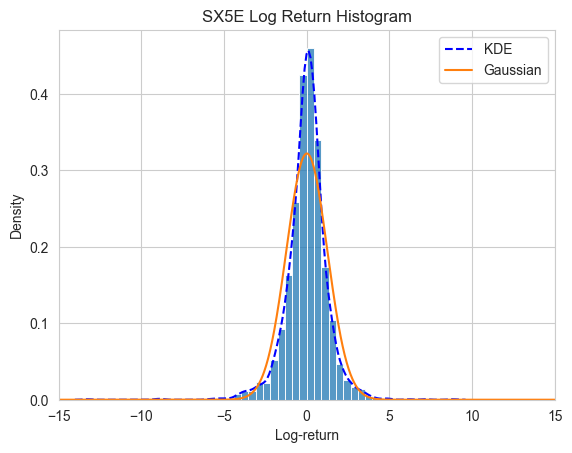

In [14]:
# Part (i)
# Plot histogram of SX5E daily log return, kernel density estimate and the fitted Gaussian pdf.

x = np.linspace(-15,15,1000)

ax = sns.histplot(data=df['log_return'], bins=50, stat="density")
sns.kdeplot(data=df['log_return'], color="blue", linestyle="--", label = 'KDE')
ax.plot(x,norm.pdf(x,mu,std),color = 'C1', label = 'Gaussian')
ax.set(xlabel='Log-return', ylabel='Density',title = 'SX5E Log Return Histogram')
ax.set_xlim(-15, 15)
ax.legend()
plt.show()

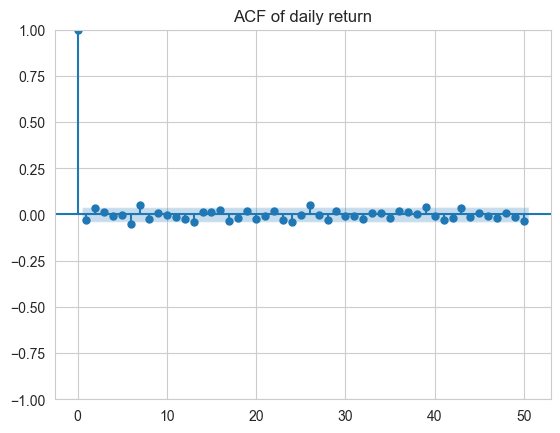

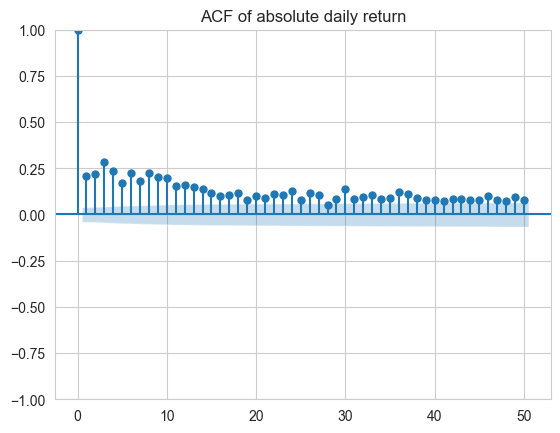

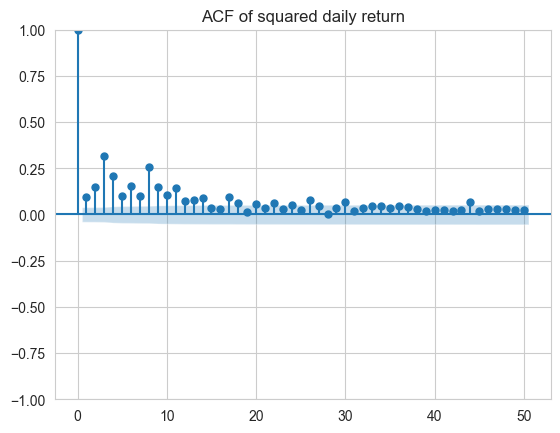

In [15]:
# Part (ii):
# Plot ACF of log return, absolute log return, and squared log return.
sm.graphics.tsa.plot_acf(df['log_return'].dropna(), lags = 50, title = 'ACF of daily return')
plt.show()
sm.graphics.tsa.plot_acf(np.abs(df['log_return']).dropna(), lags = 50, title = 'ACF of absolute daily return')
plt.show()
sm.graphics.tsa.plot_acf((df['log_return'] ** 2).dropna(), lags = 50, title = 'ACF of squared daily return')
plt.show()

In [16]:
# Part (iii): Fit a GARCH(1,1) model

model = arch_model(df['log_return'].dropna(), mean='zero', p=1, q=1, dist='normal')
# "mean=zero" refers to no ARMA component
# "dist=normal" refers to N(0,1) distribution of the white noise process Z
res = model.fit(update_freq = 9)
res.summary()

Iteration:      9,   Func. Count:     45,   Neg. LLF: 3741.9894547512663
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3741.9894547500244
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3741.99
Distribution:                  Normal   AIC:                           7489.98
Method:            Maximum Likelihood   BIC:                           7507.46
                                        No. Observations:                 2505
Date:                Sun, Nov 09 2025   Df Residuals:                     2505
Time:                        21:04:05   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0575  1.891e-02      3.041  2.355e-03 [2.045e-02,9.458e-02]
alpha[1]       0.1322  2.861e-02      4.623  3.791e-06   [7.616e-02,  0.188]
beta[1]        0.8315  3.328e-02     24.990 7.928e-138     [  0.766,  0.897]
============================================================================

Covariance estimator: robust
"""

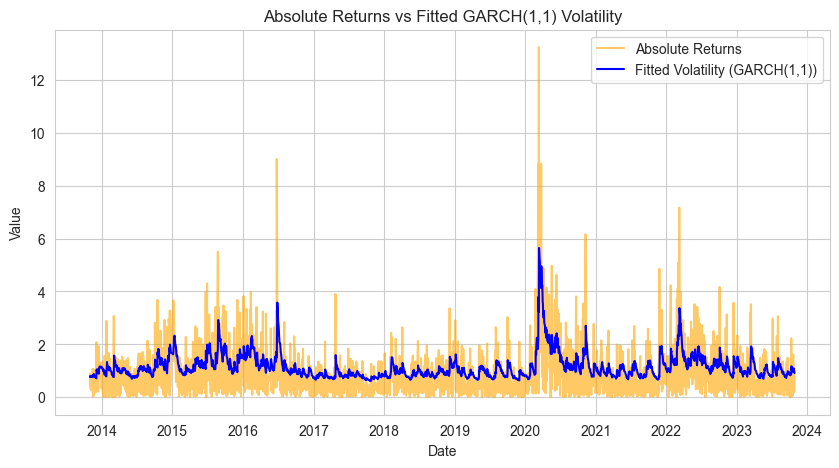

In [17]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df2 = df.dropna(subset=['log_return']).copy()
abs_ret = df2['log_return'].abs()
vol = pd.Series(res.conditional_volatility, index=df2.index)
dates = df2['Date']

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(dates, abs_ret, label='Absolute Returns', alpha=0.6, color = 'orange')
ax.plot(dates, vol, label='Fitted Volatility (GARCH(1,1))', linewidth=1.5, color = 'blue')

ax.set_title('Absolute Returns vs Fitted GARCH(1,1) Volatility')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()
plt.show()

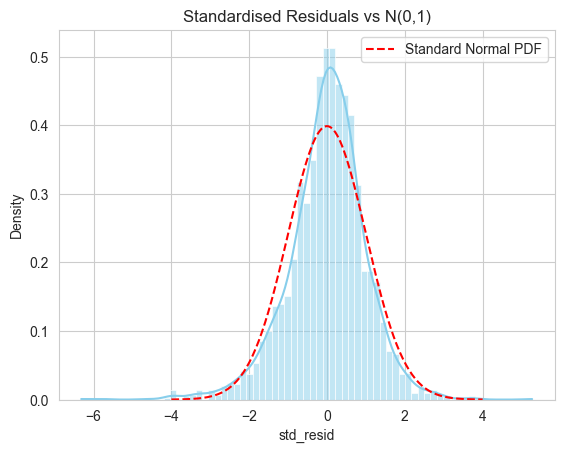

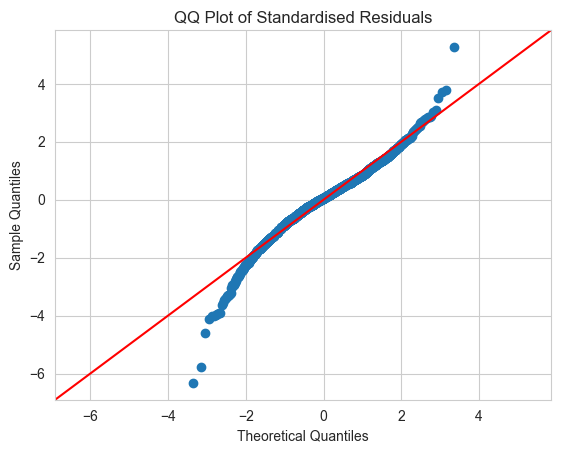

Jarque–Bera test: statistic=826.24, p-value=0.0000
As p-value is small, we reject the null hypothesis that the standardised residual obeys a distribution of N(0,1).

Anderson-Darling test:
statistic = 14.37
critical value with significance level 1% = 1.09
Therefore we reject the null hypothesis that the standardised residual obeys a distribution of N(0,1).


In [36]:
std_resid = res.std_resid
sns.histplot(std_resid, kde=True, stat='density', color='skyblue')
x = np.linspace(-4, 4, 200)
plt.plot(x, stats.norm.pdf(x), 'r--', label='Standard Normal PDF')
plt.legend()
plt.title('Standardised Residuals vs N(0,1)')
plt.show()

sm.qqplot(std_resid, line='45', fit=True)
plt.title('QQ Plot of Standardised Residuals')
plt.show()

jb_stat, jb_p = stats.jarque_bera(std_resid)
print(f'Jarque–Bera test: statistic={jb_stat:.2f}, p-value={jb_p:.4f}\n'
      f'As p-value is small, we reject the null hypothesis that the standardised residual obeys a distribution of N(0,1).\n')

ad_res = stats.anderson(std_resid, dist = 'norm')
print(f'Anderson-Darling test:\n'
      f'statistic = {ad_res.statistic:.2f}\n'
      f'critical value with significance level 1% = {ad_res.critical_values[-1]:.2f}\n'
      f'Therefore we reject the null hypothesis that the standardised residual obeys a distribution of N(0,1).')

In [23]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_resid = acorr_ljungbox(std_resid, return_df=True)
lb_sq = acorr_ljungbox(std_resid**2, return_df=True)

print("Ljung-Box test for residuals:")
print(lb_resid)
print("\nLjung-Box test for squared residuals:")
print(lb_sq)

Ljung-Box test for residuals:
     lb_stat  lb_pvalue
1   0.345500   0.556671
2   0.534177   0.765605
3   0.626204   0.890408
4   0.865873   0.929405
5   1.356488   0.929013
6   1.357565   0.968389
7   1.567780   0.979870
8   1.792460   0.986727
9   1.821502   0.993986
10  1.868157   0.997254

Ljung-Box test for squared residuals:
      lb_stat  lb_pvalue
1    0.538483   0.463062
2    1.294516   0.523479
3    4.483273   0.213787
4    4.519307   0.340264
5    6.174686   0.289590
6    6.278209   0.392757
7    6.333688   0.501371
8    6.395836   0.602983
9    6.484143   0.690654
10  11.195238   0.342511


In [81]:
index = [f'{i}' for i in range(1,10001)]
data = np.random.randn(10000)
df = pd.Series(data = data, index = index, name = 'data1')
df2 = pd.Series(data = data, index = index)
x = pd.concat([df, df2], axis = 0, names = 'First')
x.columns = ['First','Second']
x

1       -0.303160
2       -1.085785
3        0.453536
4        0.564955
5       -1.103775
           ...   
9996    -1.480137
9997     0.893023
9998     1.017933
9999     0.068392
10000    0.082075
Length: 20000, dtype: float64